In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

1 Data Preprocessing

Dataset: [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html), contains 60000 32x32x3 images from 10 different classes, 50000 training and 10000 test images

Task: Image classification task 

In [2]:
#Load the training and test datasets
training_ds, test_ds = tfds.load(
    name = "cifar10",
    split = ['train', 'test'],
    as_supervised = True
)

In [3]:
#Mapping the label number to actual textual labels
numbertolabel={0:"airplane", 1:"automobile", 2:"bird", 3:"cat",4: "deer", 5:"dog", 6:"frog", 7:"horse",8:"ship", 9:"truck"}
def itswhatagain(n):
  return numbertolabel[n]

itswhatagain(1)

'automobile'

In [4]:
def show5(data, type=tf.int64):
  #shows the first five images of the dataset
  fig, ax = plt.subplots(1,5)
  c=0
  for i in data.take(5):
      img = i[0]
      lbl = itswhatagain(int(i[1]))
      
      ax[c].imshow((tf.cast(img,dtype=type)), cmap='gray')
      ax[c].set_title(img.shape)
      ax[c].set_title(lbl)
      ax[c].axis("off")

      c+=1

(32, 32, 3)
()
tf.Tensor(7, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(8, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(4, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(4, shape=(), dtype=int64)
(32, 32, 3)
()
tf.Tensor(6, shape=(), dtype=int64)


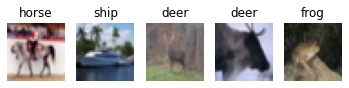

In [5]:
#Inspect the images and the labels
for sample in training_ds.take(5):
  print(sample[0].shape)
  print(sample[1].shape)
  print(sample[1])

show5(training_ds)

#Data Augmentation

We wanted to do some Data Augmentation, so that we could create more Data to train on. We followed this tutorial https://www.tensorflow.org/tutorials/images/data_augmentation?hl=en but it seemed, that they are only replacing the data in the training dataset. Therefore our idea was it to train our model on multiple datasets consisting of transformed images. If you search for #augmentationfail you can find the corresponding parts of code. Since it did not work, we came to the conclusion to drop it.

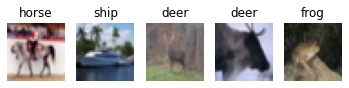

In [6]:
show5(training_ds)

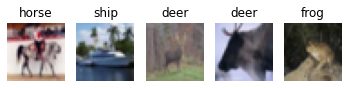

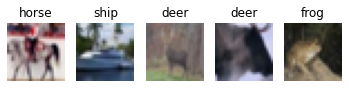

In [7]:
#augmentationfail: This complete cell

training_ds_mirrored=training_ds.map(lambda img, label:(tf.image.flip_left_right(img), label))
training_ds_saturated=training_ds.map(lambda img, label:(tf.image.adjust_saturation(img,2), label))
training_ds_bright=training_ds.map(lambda img, label:(tf.image.adjust_brightness(img, delta=0.2), label))
training_ds_cropped=training_ds.map(lambda img, label:(tf.image.central_crop(img, central_fraction=0.8), label))

augmented_ds=[training_ds_mirrored,
              #training_ds_saturated, #
              #training_ds_bright,
              training_ds_cropped]


training_ds=training_ds.map(lambda img, label:(img, label))

for i in augmented_ds:
  show5(i)

Data input pipeline

In [8]:
#Defining some normalizing functions
def normalize_0_1(x):
  #range 0 to 1
  max = tf.math.reduce_max(x)
  min = tf.math.reduce_min(x)
  result = tf.math.subtract(x, min)
  result = tf.math.divide(result,(max-min))
  return(result)

def normalize_neg_1(x):
  #range -1 to 1
  result = normalize_0_1(x)
  result = tf.math.multiply(result,2)
  result = tf.math.subtract(result,1)
  return(result)

def normalize_std(x): #This one delivered better accuracy, which is why we are using it
  #range according gaussian standard distribution
  return tf.image.per_image_standardization(x)

In [9]:
def prepare(ds, shuffle=False, augment=False): #generates a resized, normalized, shuffled,, batched and prefetched ds
  # Resize and rescale all datasets
  ds = ds.map(lambda img, label:(tf.image.resize(img, [32,32]), tf.one_hot(label, 10)))
  ds = ds.map(lambda img, label:(normalize_std(img), label))
  if shuffle:
    ds = ds.shuffle(buffer_size = 128)
  ds = ds.batch(64)

  # Use prefetching on all datasets
  ds = ds.prefetch(4)
  
  return ds


#Now we prepare all our datasets 
train_data = prepare(training_ds, shuffle=True, augment=False)


#augmentationfail-start: Here we prepare all the augemented_ds
augmented_data=[] 
for i in augmented_ds:
  augmented_data.append(prepare(i, shuffle=True, augment=False))
#augmentationfail-stop

test_data = prepare(test_ds, shuffle=True)

2. Define CNN Model

This model is build upon 8 CovLayers, 4 Maxpool and a small dense classifier layer at the end. Several BatchNormalization and Dropout Layers are added to prevent overfitting. Used activation is relu (except softmax for the output layer), as well as L2 (Lambda = 0.01) for regularization (except input/output layer) and the GlorotUniform distribution for kernel and weight initialization

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):  

  def __init__(self): 
    super(Model, self).__init__()
    #Explicit Specification of activation, regularization and kernel_initialization functions
    activation = tf.keras.activations.relu
    regularizer = tf.keras.regularizers.l2(0.01)
    initializer = tf.keras.initializers.GlorotUniform

    #Layers followed by BatchNormalization will have their activation applied afterwards
    self.cov1 = tf.keras.layers.Conv2D(filters = 64,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = None,
                                       input_shape = (32,32,3)  
                                       )
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.cov1_activation = activation
    self.cov2 = tf.keras.layers.Conv2D(filters = 64,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = activation,               
                                       )
    self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size= (2,2), strides = (2,2))
    self.dropout1 = tf.keras.layers.Dropout(rate=0.3)

    self.cov3 = tf.keras.layers.Conv2D(filters = 128,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = None
                                       )
    self.batch_norm3 = tf.keras.layers.BatchNormalization()
    self.cov3_activation = activation
    self.cov4 = tf.keras.layers.Conv2D(filters = 128,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = activation
                                       )
    self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size= (2,2),strides = (2,2))
    self.dropout2 = tf.keras.layers.Dropout(rate=0.4)

    self.cov5 = tf.keras.layers.Conv2D(filters = 256,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = None
                                       )
    self.batch_norm6 = tf.keras.layers.BatchNormalization()
    self.cov5_activation = activation
    self.cov6 = tf.keras.layers.Conv2D(filters = 256,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = activation
                                       )
    self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size= (2,2),strides = (2,2))
    self.dropout3 = tf.keras.layers.Dropout(rate=0.5)

    self.cov7 = tf.keras.layers.Conv2D(filters = 256,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = None
                                       )
    self.batch_norm7 = tf.keras.layers.BatchNormalization()
    self.cov7_activation = activation
    self.cov8 = tf.keras.layers.Conv2D(filters = 256,
                                       kernel_size = 3,
                                       kernel_initializer = initializer,
                                       kernel_regularizer = regularizer,
                                       strides = (1,1),
                                       padding = 'same',
                                       activation = activation
                                       )
    self.maxpool4 = tf.keras.layers.MaxPool2D(pool_size= (2,2),strides = (2,2))
    self.dropout4 = tf.keras.layers.Dropout(rate=0.6)

    self.flatten = tf.keras.layers.Flatten()
    #small dense classifier network
    self.hidden_layer = tf.keras.layers.Dense(units = 128,
                                              activation = None,
                                              kernel_initializer = initializer,
                                              )
    self.batch_norm8 = tf.keras.layers.BatchNormalization()
    self.hidden_layer_activation = activation
    self.output_layer = tf.keras.layers.Dense(units = 10,
                                        activation = tf.keras.activations.softmax
                                        )
  @tf.function
  def call(self, x, training=True):
    #training ensures BatchNorm and dropout is only applied during training
    #The Layers feed into each other.
    x = self.cov1(x)
    x = self.batch_norm1(x, training)
    x = self.cov1_activation(x)
    x = self.cov2(x)
    x = self.maxpool1(x)
    x = self.dropout1(x, training)
    x = self.cov3(x)
    x = self.batch_norm3(x, training)
    x = self.cov3_activation(x)
    x = self.cov4(x)
    x = self.maxpool2(x)
    x = self.dropout2(x, training)
    x = self.cov5(x)
    x = self.batch_norm6(x, training)
    x = self.cov5_activation(x)
    x = self.cov6(x)
    x = self.maxpool3(x)
    x = self.dropout3(x, training)
    x = self.cov7(x)
    x = self.batch_norm7(x, training)
    x = self.cov7_activation(x)
    x = self.cov8(x)
    x = self.maxpool4(x)
    x = self.dropout4(x, training)
    x = self.flatten(x)
    x = self.hidden_layer(x)
    x = self.batch_norm8(x, training)
    x = self.hidden_layer_activation(x)
    x = self.output_layer(x)
    return x

3.) Training

In [11]:

#General Parameters
trainforNepochs=75                                    
learning_rate=0.0002                                       
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.CategoricalCrossentropy()       #we use categorical cross entropy as lossfunction
optimizer = tf.keras.optimizers.Adam(learning_rate)           #we use ADAM as optimizer

model = Model()                          

In [12]:
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    #Since we use L2 Regularization, we ensure that we take this penality score into account in our loss
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    #Since we use L2 Regularization, we ensure that we take this penality score into account in our loss
    sample_test_loss = loss_function(target, prediction).numpy() + tf.reduce_sum(model.losses)
    #Comparing the ratio of rightly classified images by looking at the index with max. probability 
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [13]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model, test_data, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model, train_data, lossfunction)
train_losses.append(train_loss)

In [14]:
#After training once the model is built and we can look at its architecture and its parameters
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512   

In [15]:
def viz(train_losses,test_losses,test_accuracies):
  plt.figure()
  line1, = plt.plot(train_losses,'r--')
  line2, = plt.plot(test_losses, 'b-')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

  # One plot training and test accuracy.
  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()

#Training

In [16]:
def highest_index(Array):
  x=max(Array)
  return x, Array.index(x)

This Plot was generated after 2 Epochs of training.
The test accuracy was: 0.620421974522293 .
The highest accuracy so far was 0.620421974522293 in epoch 2


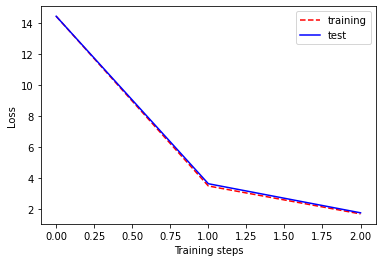

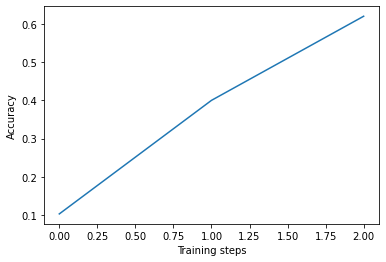

This Plot was generated after 10 Epochs of training.
The test accuracy was: 0.7299960191082803 .
The highest accuracy so far was 0.7711982484076433 in epoch 9


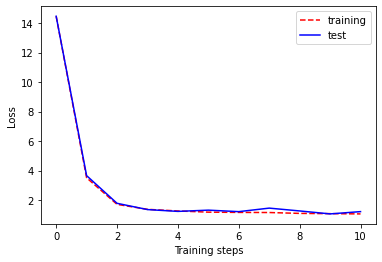

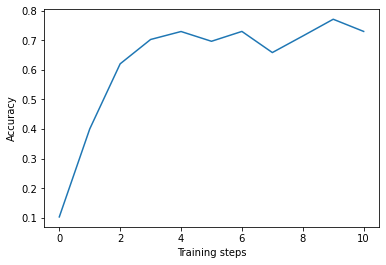

This Plot was generated after 20 Epochs of training.
The test accuracy was: 0.785828025477707 .
The highest accuracy so far was 0.7962778662420382 in epoch 13


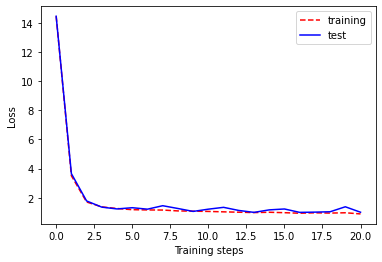

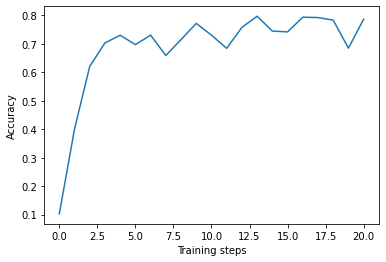

This Plot was generated after 30 Epochs of training.
The test accuracy was: 0.8039410828025477 .
The highest accuracy so far was 0.8187699044585988 in epoch 29


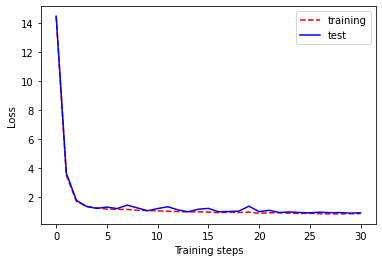

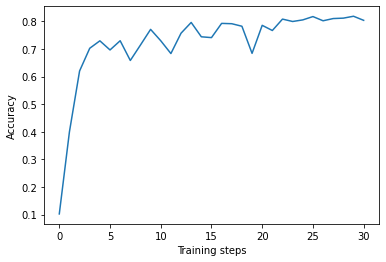

This Plot was generated after 40 Epochs of training.
The test accuracy was: 0.8533041401273885 .
The highest accuracy so far was 0.8533041401273885 in epoch 40


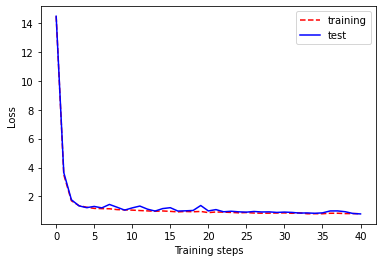

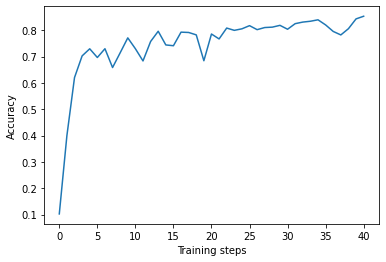

This Plot was generated after 50 Epochs of training.
The test accuracy was: 0.8246417197452229 .
The highest accuracy so far was 0.8533041401273885 in epoch 40


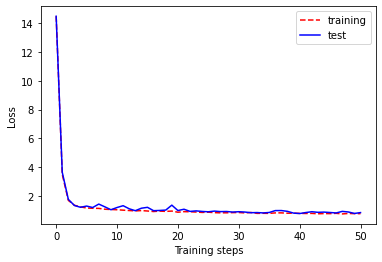

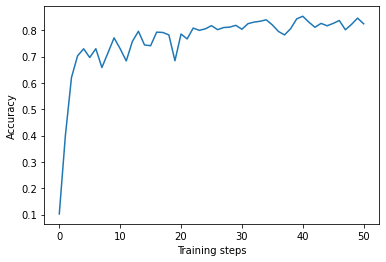

This Plot was generated after 60 Epochs of training.
The test accuracy was: 0.8376791401273885 .
The highest accuracy so far was 0.8562898089171974 in epoch 53


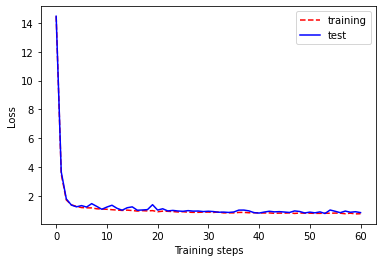

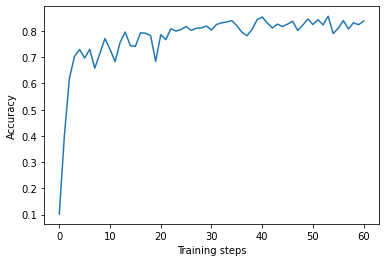

This Plot was generated after 70 Epochs of training.
The test accuracy was: 0.8146894904458599 .
The highest accuracy so far was 0.8562898089171974 in epoch 53


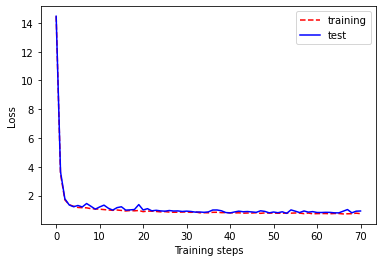

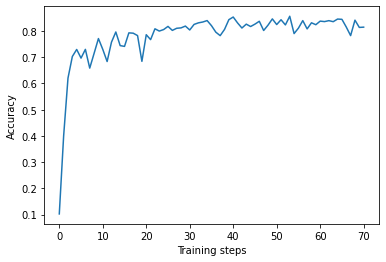

This Plot was generated after 75 Epochs of training.
The test accuracy was: 0.863156847133758 .
The highest accuracy so far was 0.863156847133758 in epoch 75


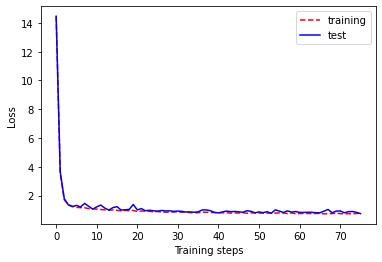

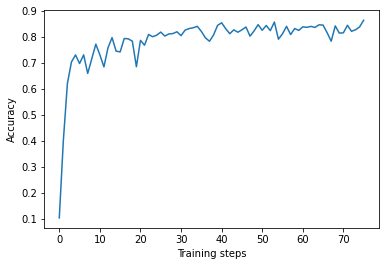

Finished after 1741.0 seconds.


In [17]:
# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #!!!!!!!!!!!!just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print("",end="\r")
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+"[1/"+str(len(augmented_data)+1)+"]. Time remaining:", time_remaining, "seconds.       "+"["+"="*int((epoch/trainforNepochs)*100)+"-"*int(((trainforNepochs-epoch)/trainforNepochs)*100)+"]", end="")
    #!!!!!!!!!!!end of the runtime approximation
    


    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:                           #Training the model as long as we have training data
        train_loss = train_step(model, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    
    #augmentationfail-start
    #Feeding the datasets of every augmentation into the CNN
    """
    aug_counter=2
    for i in augmented_data:
      print("",end="\r")
      print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+"["+str(aug_counter)+"/"+str(len(augmented_data)+1)+"]. Time remaining:", time_remaining, "seconds.       "+"["+"="*int((epoch/trainforNepochs)*100)+"-"*int(((trainforNepochs-epoch)/trainforNepochs)*100)+"]", end="")
      for (input,target) in i:                           #we train it again, but this time with the mirrored data
          train_loss = train_step(model, input, target, lossfunction, optimizer)
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
      aug_counter+=1"""
    #augmentationfail-stop


    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model, test_data, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    #Generating a graph after the first two epochs and after every tenth of them
    if (epoch+1)%10==0 or epoch+1==2 or epoch+1==trainforNepochs:
      print("",end="\r")
      print("This Plot was generated after", str(epoch+1), "Epochs of training.")
      print("The test accuracy was:", test_accuracies[-1],".")
      maxx,index=highest_index(test_accuracies)
      print("The highest accuracy so far was", maxx, "in epoch", index)
      viz(train_losses,test_losses,test_accuracies)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")


#4 Final Visualization
Visualize the final accuracy and loss for training and test data using matplotlib.

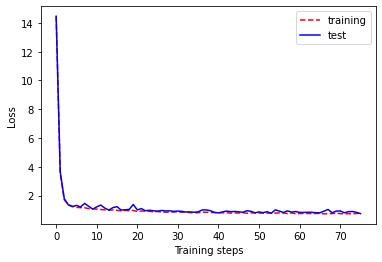

In [18]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses,'r--')
line2, = plt.plot(test_losses, 'b-')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

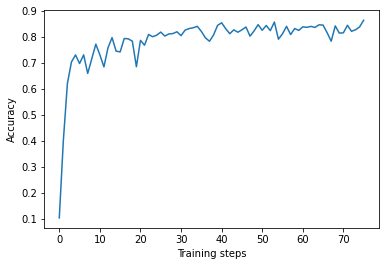

In [19]:
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

# History of Changes 
[Default: n(epochs) = 10] For tracking the impact of changes on the network performance (accuracy)

1.   Start (Flatten(), 6 Conv, Dropout, L2 Regulator, 
Uniform Initializer): **0.5225**
2.   Cov1 (Filter 16 => 32): **0.5514** => accepted
3.   LR (0.008 => 0.001): **0.5966** => accepted
4.   Cov1,Cov2 (Filter 32 => 64): **0.6422** => accepted
5.   Cov6 (Filter 256 => 512): **0.6162** => rejected
6.   Dropout2, Dropout4 (=> replace by BatchNormalization): **0.7968** => accepted ( [n = 30]: 0.8371 ~ slighty overfit, [n = 50]: 0.841 ~ slighty overfit )
7.   Add 3 BatchNormalization (between Cov1,Cov2 ; Cov3,Cov4 ; Cov5,Cov6): **0.8163** => accepted ( [n = 30]:   0.8525 ~ slighty overfit)
8.   Add 3 BatchNormalization (after Cov2, Cov4, Cov6): **0.8011** => rejected
9.   Add 3 BatchNormalization, Change 2 BatchNorm to Dropout: **0.7553** => rejected
10.  Add 3 BatchNormalization, Change 2 BatchNorm to Dropout, Cov4 (128 => 256), Cov6 (256 => 512), HiddenLayer (128 => 256): **0.7845** => rejected
11.  LR (0.001 => 0.002): **0.8173** => accepted
12.  Add Cov7 before Flatten:  **0.8252** => accepted ([n = 30]: 0.8384 ~ slightly overfitting)
13.  Add Cov8 + BatchNorm between Cov7/Cov8: **0.7825** => rejected
14.  Switch Flatten to GlobalAvgPooling: **0.8014** => rejected
15.  Add Cov8: **0.8322** => accepted ([n = 30]: 0.8395 ~ no overfitting)
16.  Add BatchNormalize (Cov7,Cov8), Maxpool, Dropout: [n = 30] **0.8449**  => accepted
17.  Change Activation Function (Relu -> LeakyRelu): **0.8325** => rejected
18.  Remove all 3 Dropout Layers: **0.8026** => rejected
19.  Apply the activation for BatchNorm after Normalizing: **0.8285** => accepted (since its the proper way)
20.  Cov7,Cov8 (Filter 256 => 512): **0.8212** => rejected
21.  Change Kernel_Initializer from Uniform to Glorot_Uniform: [n = 30]: **0.8408** => accepted
22.  Change Batch_Size (64 => 96): [n = 30]: **0.8263** => rejected
23.  Change Regularization factor (0.01 => 0.001): [n = 30]: **0.8419** ~ strong overfit => rejected
24.  Use Elu instead of Relu: [n = 30] **0.7974** => rejected
25.  Half all filter sizes: [n = 30] **0.8258** => rejected
26.  Use Settings of 16.): [n = 75] **0.8645** ~ slightly overfit
27.  Replace Batch_Norm5 with Dropout: [n = 75] **0.8608** ~ slightly overfit (better)
28.  increase dropout rates by 0.1 each: [n = 75] **0.8591** ~ very little to no overfitting
29. changed normalization-function to neg one: [n = 75] **0.8611** ~ very little to no overfitting
30. changed normalization-function to normalize_std: [n = 75] **0.8637** ~ very little to no overfitting
31. added the data-augmentation loops for mirrored and saturated.



Further Ideas


*   Change Size of Layers (Filters)
*   Change activation functions
*   Add BatchNorm to all Covs
*   Remove all Dropouts (will increase overfit rate!)
*   train more epochs (overfitting is the issue here)



Save the Weights

In [20]:
model.save_weights('cifar10.h5')